In [8]:
import api_nyt as nyt
import manage_articles as mng
import statistics
import datetime
import pickle
import timeseries
articles = mng.load_articles("nyt2019.json")

In [2]:
#headlines = mng.getWordCounts(articles,'headline')
#with open("wordCount2019.txt", "wb") as fp:
#    pickle.dump(headlines, fp)
#top = mng.getTopWordsForWeek(headlines)
#distinctWords = mng.getDistinctWords(headlines)

headlines = []
with open("wordCount2019.txt", "rb") as fp:
    headlines = pickle.load(fp)
top = mng.getTopWordsForWeek(headlines)
distinctWords = mng.getDistinctWords(headlines)

In [3]:
res = []
for w in distinctWords:
    res.append((w,mng.getCountPerWeek(headlines,w)))

In [4]:
var = []
for r in range(len(res)):
    x = [res[r][1][i][1] for i in range(len(res[0][1]))]
    y = [res[r][1][i][0] for i in range(len(res[0][1]))]
    v = statistics.getVariance(x)
    o = statistics.findOutliers(x)
    var.append((res[r][0],v,x,y,o))

In [5]:
var_sorted = sorted(var,key=lambda x: x[2], reverse=True)

In [22]:
tp = timeseries.Timeseries(var_sorted[0][0],var_sorted[0][3],var_sorted[0][2])

tp

[datetime.date(2018, 12, 31), datetime.date(2019, 1, 7), datetime.date(2019, 1, 14), datetime.date(2019, 1, 21), datetime.date(2019, 1, 28), datetime.date(2019, 2, 4), datetime.date(2019, 2, 11), datetime.date(2019, 2, 18), datetime.date(2019, 2, 25), datetime.date(2019, 3, 4), datetime.date(2019, 3, 11), datetime.date(2019, 3, 18), datetime.date(2019, 3, 25), datetime.date(2019, 4, 1), datetime.date(2019, 4, 8), datetime.date(2019, 4, 15), datetime.date(2019, 4, 22), datetime.date(2019, 4, 29), datetime.date(2019, 5, 6), datetime.date(2019, 5, 13), datetime.date(2019, 5, 20), datetime.date(2019, 5, 27), datetime.date(2019, 6, 3), datetime.date(2019, 6, 10), datetime.date(2019, 6, 17), datetime.date(2019, 6, 24), datetime.date(2019, 7, 1), datetime.date(2019, 7, 8), datetime.date(2019, 7, 15), datetime.date(2019, 7, 22), datetime.date(2019, 7, 29), datetime.date(2019, 8, 5), datetime.date(2019, 8, 12), datetime.date(2019, 8, 19), datetime.date(2019, 8, 26), datetime.date(2019, 9, 2), d

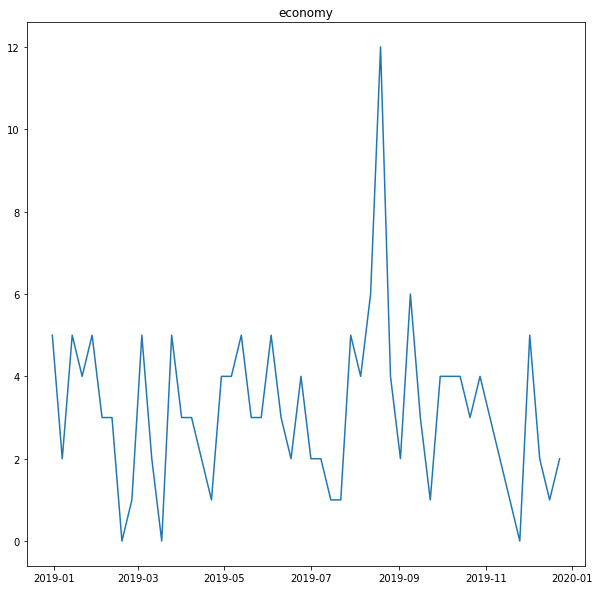

In [66]:
wordIndex = 47
dates = []
for d in range(len(out[wordIndex][3])):
    dates.append(getDateRangeFromWeek(out[wordIndex][3][d][0],out[wordIndex][3][d][1]))
statistics.plot(out[wordIndex][0],out[wordIndex][2],dates)